In [8]:
from transformers import pipeline
from nltk import sent_tokenize
import nltk
import torch
import glob
import pysrt
import platform
import re
import pandas as pd
from collections import defaultdict
import numpy as np

In [9]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /Users/homedirel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load Model

In [10]:
model_name = "facebook/bart-large-mnli"
device = torch.device("cpu")  # Default to CPU

if platform.system() == "Darwin" and torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")

print(f"Using device: {device}")

Using device: mps


In [11]:
def load_model(device):
    theme_classifier = pipeline(
        "zero-shot-classification",
        model=model_name,
        device=device
    )

    return theme_classifier

In [12]:
theme_classifier = load_model(device)

/Users/homedirel/ML/NLP_PROJECT/.venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [13]:
theme_list = ["dialogue","battle", "friendship", "hope", "sacrifice", "self development", "betrayal", "love"]
theme_classifier(
    "I gave him a right hook then a left jab",
    theme_list,
    multi_label=True
)

{'sequence': 'I gave him a right hook then a left jab',
 'labels': ['battle',
  'self development',
  'hope',
  'sacrifice',
  'dialogue',
  'betrayal',
  'love',
  'friendship'],
 'scores': [0.9121252298355103,
  0.47499823570251465,
  0.08781787008047104,
  0.04499977082014084,
  0.02013278566300869,
  0.012040315195918083,
  0.004292317666113377,
  0.002817203989252448]}

In [14]:
def get_season_episode(episode_name):
    match = re.search(r"\[(\d{3})\]", episode_name)

    if match:
        episode_number = match.group(1)  # "404"
        season = episode_number[0]       # "4"
        episode = episode_number[1:]     # "04"
        
        return (int(season), int(episode))
    else:
        return (0, 0)


In [15]:
def load_dataset(path):

    scripts = []
    episode_num = []


    files = glob.glob(pathname=path)

    for file in files:
        
        lines = []
        subs = pysrt.open(file, encoding='iso-8859-1')

        for sub in subs:
            lines.append(
                sub
                .text
                .replace("\n", " ")
                .replace("<i>", ""))
        
        episode_name = file.split("/")[-1]
        season, episode = get_season_episode(episode_name)
        scripts.append(" ".join(lines))
        episode_num.append(episode)
    
        
    df = pd.DataFrame.from_dict({"episode": episode_num, "script": scripts})
    return df

In [16]:
PATH = "../../DATA/NLP_DATA/4_season_office/*.srt"         
data = load_dataset(PATH)

data.head()

,episode,script
0,4,Coat! Michael just rent The Devil wears Prada....
1,14,"Hello, this is Dwight Schrute. - Hello? - Hell..."
2,6,"Dunder Mifflin, this is Rolando. Oh yes, she's..."
3,1,Okay. Well... I did not get the job in New-Yor...
4,12,"Everybody! Everybody! Listen up, I need your i..."


In [17]:
script = data.iloc[0]["script"]
script_sentences = sent_tokenize(script)

script_batches = []

for i in range(0, len(script_sentences), 20):
    sent = " ".join(script_sentences[i:i+20])
    script_batches.append(sent)

script_batches[:3]



["Coat! Michael just rent The Devil wears Prada.</i> He has his netflix sent here to the office and he watches them in pieces when things are slow. Steak! Where's my steak? He's a big Meryl Streep fan, so I shouldn't be surprised that he's identified with her character. Get me Armani. A suit? On the phone. The main company number? 'Cause I'm gonna have to... Where's Armani? He's on the phone. Too slow. You're not going to Paris. I'm so much better than you are. I owe you an apology. - You finished the movie. - Yeah, it was awesome. Big surprise ending. Won't ruin it for you. No, go ahead.",
 'Meryl Streep is the bad guy. You never see it coming. Anyway, if I was mean in any way to you, I\'m sorry. I just want what\'s best for you, Minushka. Macushla. He\'s watching Million Dollar Baby.</i> He\'s gonna try to kill me. T</i> Tr</i> Tra</i> Tran</i> Trans</i> Transc</i> Transcr</i> Transcri</i> Transcrip</i> Transcript</i> Transcript</i> Transcript:</i> Transcript:</i> Transcript: S</i> T

In [18]:
theme_output = theme_classifier(
    script_batches[:2],
    theme_list,
    multi_label=True
)



In [19]:
theme_output

[{'sequence': "Coat! Michael just rent The Devil wears Prada.</i> He has his netflix sent here to the office and he watches them in pieces when things are slow. Steak! Where's my steak? He's a big Meryl Streep fan, so I shouldn't be surprised that he's identified with her character. Get me Armani. A suit? On the phone. The main company number? 'Cause I'm gonna have to... Where's Armani? He's on the phone. Too slow. You're not going to Paris. I'm so much better than you are. I owe you an apology. - You finished the movie. - Yeah, it was awesome. Big surprise ending. Won't ruin it for you. No, go ahead.",
  'labels': ['dialogue',
   'sacrifice',
   'self development',
   'betrayal',
   'battle',
   'hope',
   'friendship',
   'love'],
  'scores': [0.909151017665863,
   0.7216111421585083,
   0.5595808029174805,
   0.20029251277446747,
   0.10084427148103714,
   0.08791906386613846,
   0.06756991147994995,
   0.019578343257308006]},
 {'sequence': 'Meryl Streep is the bad guy. You never se

In [20]:
theme = defaultdict(list)

for output in theme_output:

    for label, score in zip(output["labels"], output["scores"]):
        theme[label].append(score)

theme_output = theme_classifier(
    script_batches[:2],
    theme_list,
    multi_label=True
)

themes = defaultdict(list)

for output in theme_output:
    
    for label, score in zip(output["labels"], output["scores"]):
        themes[label].append(score)

themes

defaultdict(list,
            {'dialogue': [0.909151017665863, 0.9822323322296143],
             'sacrifice': [0.7216111421585083, 0.7828366756439209],
             'self development': [0.5595808029174805, 0.6068390011787415],
             'betrayal': [0.20029251277446747, 0.7097246050834656],
             'battle': [0.10084427148103714, 0.3379935026168823],
             'hope': [0.08791906386613846, 0.07085894048213959],
             'friendship': [0.06756991147994995, 0.5692187547683716],
             'love': [0.019578343257308006, 0.2923889756202698]})

In [21]:
def get_theme_inference(script):

    script_sentence = sent_tokenize(script)
    script_batches = []

    for i in range(0, len(script_sentence), 20):
        sent = " ".join(script_sentence[i:i+20])
        script_batches.append(sent)

    theme_output = theme_classifier(
        script_batches[:2],
        theme_list,
        multi_label=True
    )

    themes = defaultdict(list)

    for output in theme_output:

        for label, score in zip(output["labels"], output["scores"]):
            themes[label].append(score)

    themes = {theme: np.mean(np.array(score)) for theme, score in themes.items()}

    return themes

In [22]:
data = data.head(2)

In [23]:
output_theme = data["script"].apply(get_theme_inference)


In [24]:
output_theme

0    {'dialogue': 0.9456916749477386, 'sacrifice': ...
1    {'dialogue': 0.9526321589946747, 'self develop...
Name: script, dtype: object

In [25]:
theme_df = pd.DataFrame(output_theme.tolist())

In [26]:
data

,episode,script
0,4,Coat! Michael just rent The Devil wears Prada....
1,14,"Hello, this is Dwight Schrute. - Hello? - Hell..."


In [27]:
data[theme_df.columns] = theme_df

In [28]:
data

,episode,script,dialogue,sacrifice,self development,betrayal,battle,hope,friendship,love
0,4,Coat! Michael just rent The Devil wears Prada....,0.945692,0.752224,0.583210,0.455009,0.219419,0.079389,0.318394,0.155984
1,14,"Hello, this is Dwight Schrute. - Hello? - Hell...",0.952632,0.485998,0.513272,0.351178,0.172694,0.153812,0.322012,0.134027


In [29]:
# data.drop("dialogue", axis=1)

In [38]:
theme_output = data.drop(["episode", "script"], axis=1).sum().reset_index()
theme_output.columns = ["theme", "score"]
theme_output

,theme,score
0,dialogue,1.898324
1,sacrifice,1.238222
2,self development,1.096482
3,betrayal,0.806187
4,battle,0.392113
5,hope,0.233201
6,friendship,0.640406
7,love,0.290010


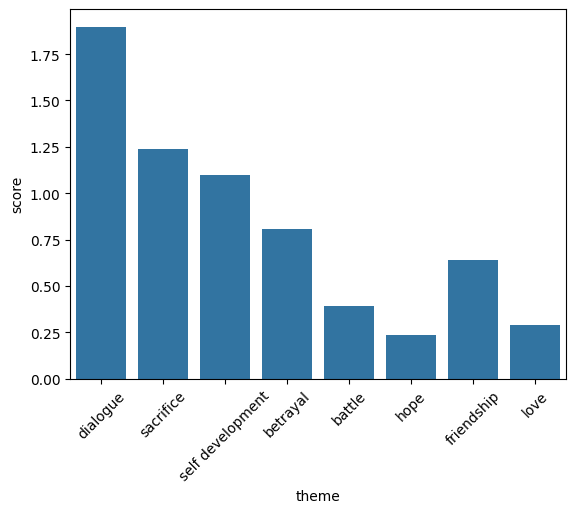

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(data = theme_output, x="theme", y="score")
plt.xticks(rotation=45)
plt.show()

